CNN신경망

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import scipy

# 추가적인 모듈
import torchvision.datasets as dset # vision 데이터를 읽어오는 역할
import torchvision.transforms as transforms # 이미지를 필요에 따라 변환해주는 역할을 하는 모듈
from torch.utils.data import DataLoader # Data의 batch size 설정 및 random하게 섞기 등을 해주는 모듈

/home/vision/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 30

In [15]:
def conv_2_block(in_dim, out_dim) -> nn.Sequential():
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    return model

def conv_3_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    return model

In [16]:
class VGG16(nn.Module):
    def __init__(self, base_dim, num_classes = 1000) -> None:
        super(VGG16, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.feature = nn.Sequential(
            conv_2_block(3, base_dim),
            conv_2_block(base_dim, 2*base_dim),
            conv_3_block(2*base_dim, 4*base_dim),
            conv_3_block(4*base_dim, 8*base_dim),
            conv_3_block(8*base_dim, 8*base_dim)
        )
        self.classifier = nn.Sequential(
            nn.Linear(8*base_dim * 7 * 7, 100),
            nn.ReLU(True),
            nn.Linear(100, 20),
            nn.ReLU(True),
            nn.Linear(20, num_classes)
        )

    def forward(self, x) -> torch.Tensor: 
        x = self.feature(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [17]:
CIFAR10_train=dset.CIFAR10("../DataSets/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
CIFAR10_test=dset.CIFAR10("../DataSets/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
train_loader = DataLoader(CIFAR10_train, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
test_loader = DataLoader(CIFAR10_test, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)

In [19]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=VGG16(num_classes=100, base_dim=32).to(device=device)
loss_func=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=learning_rate)
loss_array = []

In [20]:
optimizer=optim.Adam(model.parameters(), lr=learning_rate/30)
for i in range(num_epoch):
    print("epoch", i, "is start")
    for j, [img, label] in enumerate(train_loader):
        x = img.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output= model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if j % 100 == 0:
            loss_array.append(loss.cpu().detach().numpy())
    print(loss)

epoch 0 is start
tensor(4.0598, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 1 is start
tensor(3.6738, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 2 is start
tensor(3.4347, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 3 is start
tensor(3.1894, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 4 is start
tensor(2.8910, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 5 is start
tensor(2.5778, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 6 is start
tensor(2.4045, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 7 is start
tensor(2.2268, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 8 is start
tensor(1.8888, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 9 is start
tensor(1.8185, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 10 is start
tensor(1.5070, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 11 is start
tensor(1.3464, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 12 is start
tensor(1.1692, device='cuda:0', grad_fn=<NllLossBackward

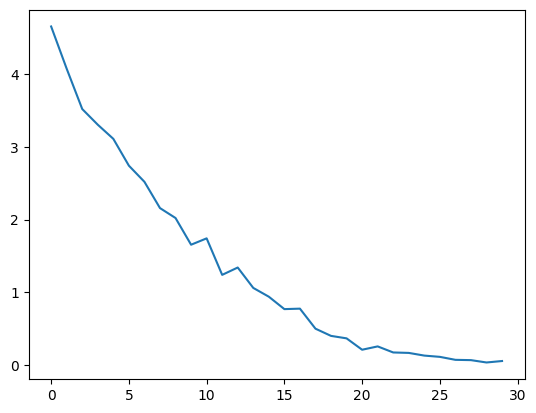

In [21]:
import matplotlib.pyplot as plt
plt.plot(loss_array[:])
plt.show()

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        x = img.to(device)
        y_ = label.to(device)

        output = model.forward(x)
        _, output_index = torch.max(output, 1)

        total += label.size(0)
        correct += (output_index == y_).sum().float()

    print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 45.055511474609375
